# A Basic Deep Neural Network for flooding audio recognition

In [1]:
import os
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


We load the datas and labels

In [2]:
data_dir = 'sound_full'
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['no' 'yes']


In [3]:

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(f'{data_dir}/{commands[0]}')))
print('Example file tensor:', filenames[0])

Number of total examples: 2774
Number of examples per label: 1481
Example file tensor: tf.Tensor(b'sound_full/no/rain-speech-914.wav', shape=(), dtype=string)


The train/val/test split

In [4]:
train_size = int(len(filenames)*0.8)
val_size = int(len(filenames)*0.9)
train_files = filenames[:train_size]
val_files = filenames[train_size: val_size]
test_files = filenames[val_size:]


print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 2219
Validation set size 277
Test set size 278


# Preprocessing


In [5]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
  return tf.squeeze(audio, axis=-1)

In [6]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] 

In [7]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

We turn the wave-file into tensors and collect them into a dataset

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Plotting of some wave file:

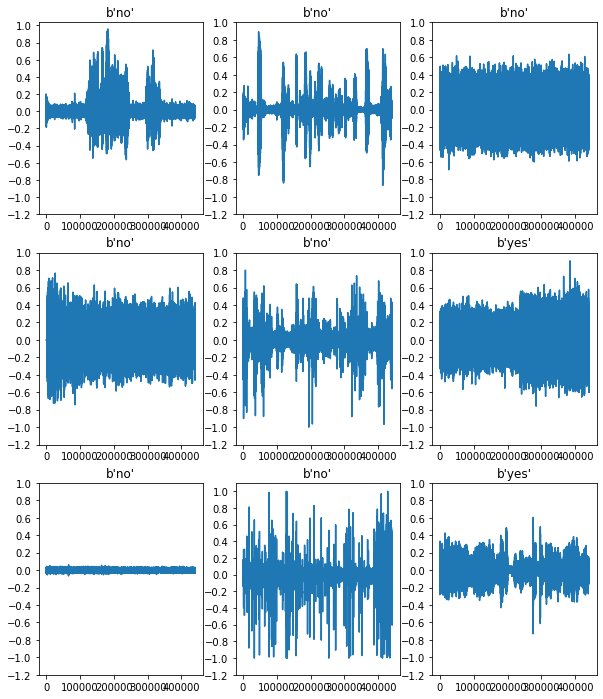

In [9]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy()[0:10*44100])
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy()
  ax.set_title(label)

plt.show()

We compute the spectrogram of each data:

In [10]:
def get_spectrogram(waveform):
  # Padding for files with less than 441000 samples
  #lower_bound = np.random.randint(waveform.get_shape()[0])
  #waveform = waveform[lower_bound: lower_bound+441000]
  zero_padding = tf.zeros([441000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [11]:
for waveform, label in waveform_ds.take(5):
  label = label.numpy()
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))


Label: b'no'
Waveform shape: (441000,)
Spectrogram shape: (3444, 129)
Audio playback


Example of the plot a data and its spectrogram

In [12]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, waveform.shape[0]])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

We regroup all the spectrograms in a tensor

In [14]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [15]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


Some spectogram plots:

<ipython-input-12-9d8460ca3c5a>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)
<ipython-input-12-9d8460ca3c5a>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


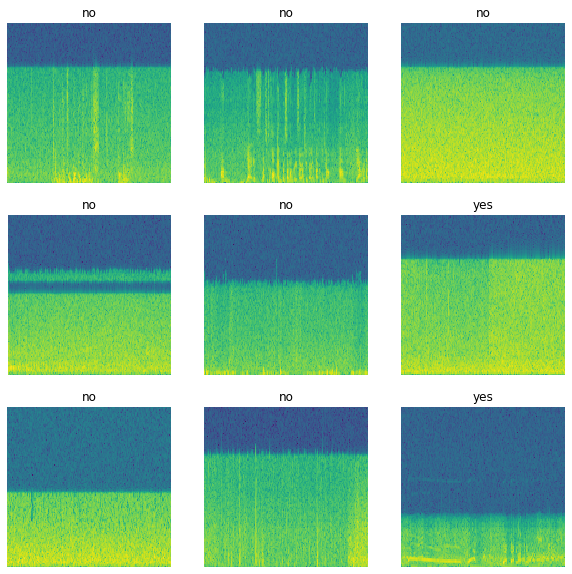

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()


Preprocessing of the val/test sets

In [17]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [18]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)


In [19]:
batch_size = 5
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [20]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# Construction of the model and training
We build and train a simple neural network

In [29]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

Input shape: (3444, 129, 1)


In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [31]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
)

Epoch 1/10
444/444 [==============================] - 5s 11ms/step - loss: 0.6850 - accuracy: 0.5845 - val_loss: 0.6759 - val_accuracy: 0.6209
Epoch 2/10
444/444 [==============================] - 5s 12ms/step - loss: 0.6703 - accuracy: 0.5994 - val_loss: 0.6691 - val_accuracy: 0.6173
Epoch 3/10
444/444 [==============================] - 6s 13ms/step - loss: 0.6578 - accuracy: 0.6255 - val_loss: 0.6739 - val_accuracy: 0.6245
Epoch 4/10
444/444 [==============================] - 6s 14ms/step - loss: 0.6363 - accuracy: 0.6444 - val_loss: 0.6699 - val_accuracy: 0.6101
Epoch 5/10
444/444 [==============================] - 5s 12ms/step - loss: 0.6212 - accuracy: 0.6571 - val_loss: 0.6812 - val_accuracy: 0.6209
Epoch 6/10
444/444 [==============================] - 5s 12ms/step - loss: 0.5956 - accuracy: 0.6679 - val_loss: 0.7006 - val_accuracy: 0.6065
Epoch 00006: early stopping


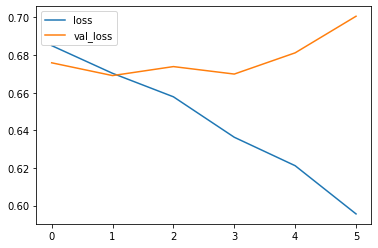

In [32]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

We compute accuracy and confusion matrix

In [33]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [34]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 68%


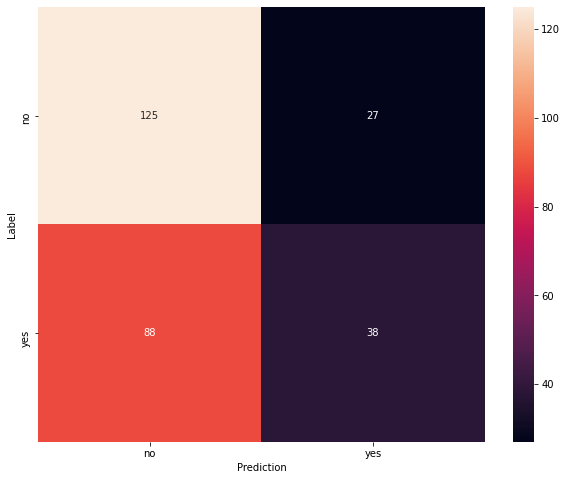

In [27]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [32]:
model.save('test_model')

INFO:tensorflow:Assets written to: test_model/assets
